 ### Install & Import Dependencies

In [ ]:
!pip install pyspark h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.6 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, hour, to_timestamp, dayofweek, month, mean, lpad
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, PCA, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

### Initialize Spark & H2O

In [ ]:
spark = SparkSession.builder.appName("FlightDelayPrediction").getOrCreate()
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5fmn_ubo
  JVM stdout: /tmp/tmp5fmn_ubo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp5fmn_ubo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_cbi7y1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Big Data Aviation Data/flights_sample_3m.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)
df = df.withColumn("DELAYED", when(col("ARR_DELAY") > 15, 1).otherwise(0))
df_clean = df.dropna(subset=["DEP_DELAY", "ARR_DELAY", "DISTANCE", "DELAYED"])

###  EDA - Correlation & Delay Patterns

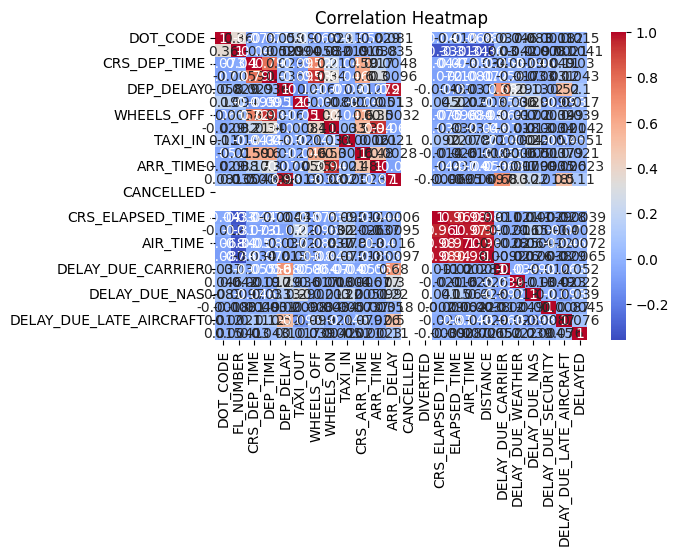

In [ ]:
numerical_cols = [col_name for col_name, dtype in df_clean.dtypes if dtype in ('int', 'double')]
corr_pd = df_clean.select(*numerical_cols).dropna().toPandas()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_pd.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

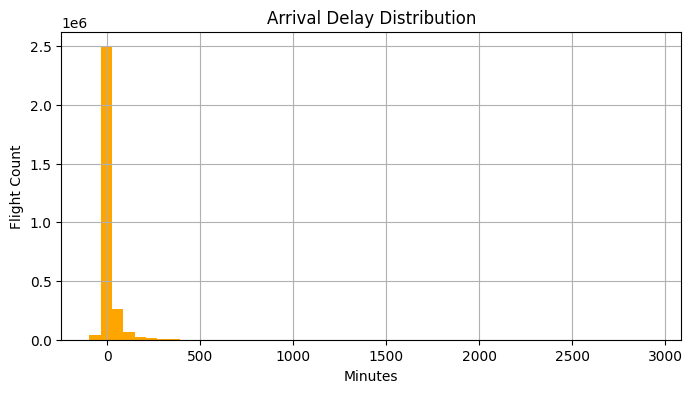

In [ ]:
delay_pd = df_clean.select("ARR_DELAY").dropna().toPandas()
plt.figure(figsize=(8, 4))
plt.hist(delay_pd["ARR_DELAY"], bins=50, color='orange')
plt.title("Arrival Delay Distribution")
plt.xlabel("Minutes")
plt.ylabel("Flight Count")
plt.grid(True)
plt.show()


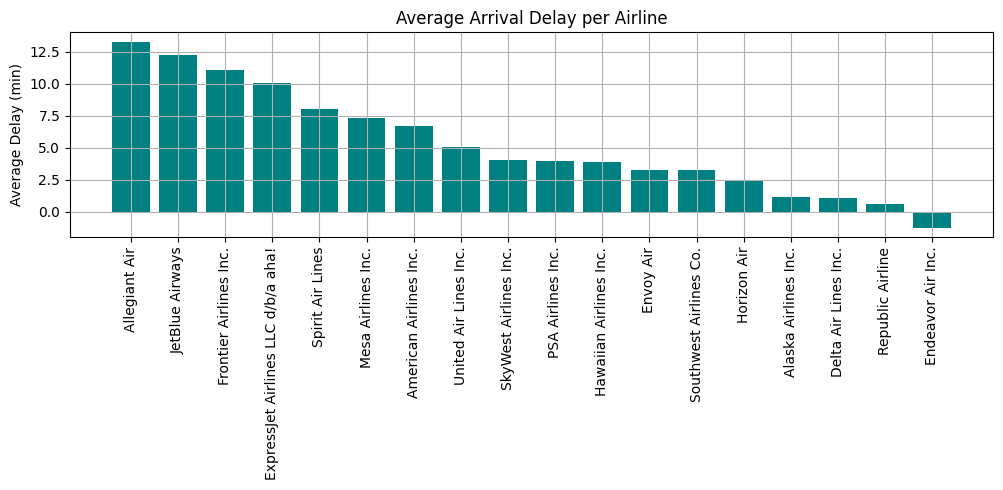

In [ ]:
avg_delay = df_clean.groupBy("AIRLINE").agg(mean("ARR_DELAY").alias("avg_delay"))
avg_delay_pd = avg_delay.toPandas().sort_values("avg_delay", ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(avg_delay_pd["AIRLINE"], avg_delay_pd["avg_delay"], color='teal')
plt.xticks(rotation=90)
plt.title("Average Arrival Delay per Airline")
plt.ylabel("Average Delay (min)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Engineering

In [ ]:
feature_cols = ["DEP_DELAY", "DISTANCE"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_ml = assembler.transform(df_clean).select("features", "DELAYED")
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

### Models

In [ ]:
lr = LogisticRegression(labelCol="DELAYED", featuresCol="features")
lr_model = lr.fit(train)
pred_lr = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="DELAYED")
auc_lr = evaluator.evaluate(pred_lr)

In [ ]:
rf = RandomForestClassifier(labelCol="DELAYED", featuresCol="features", maxBins=128)
gbt = GBTClassifier(labelCol="DELAYED", featuresCol="features", maxBins=128)
dt = DecisionTreeClassifier(labelCol="DELAYED", featuresCol="features", maxBins=128)
nb = NaiveBayes(labelCol="DELAYED", featuresCol="features")

rf_model = rf.fit(train)
gbt_model = gbt.fit(train)
dt_model = dt.fit(train)

# Evaluate all
auc_rf = evaluator.evaluate(rf_model.transform(test))
auc_gbt = evaluator.evaluate(gbt_model.transform(test))
auc_dt = evaluator.evaluate(dt_model.transform(test))



In [ ]:
# Evaluate all
auc_rf = evaluator.evaluate(rf_model.transform(test))
auc_gbt = evaluator.evaluate(gbt_model.transform(test))
auc_dt = evaluator.evaluate(dt_model.transform(test))

In [ ]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
boosted = GBTClassifier(labelCol="DELAYED", featuresCol="pcaFeatures", maxIter=30)
hybrid_pipeline = Pipeline(stages=[pca, boosted])
hybrid_model = hybrid_pipeline.fit(train)
pred_hybrid = hybrid_model.transform(test)
auc_hybrid = evaluator.evaluate(pred_hybrid)

### Evaluation - Metrics + Confusion Matrix + ROC

In [ ]:
def compute_metrics(pred_df, model_name):
    cm = pred_df.groupBy("DELAYED", "prediction").count().toPandas().pivot(index="DELAYED", columns="prediction", values="count").fillna(0)
    TP = cm.loc[1, 1] if (1 in cm.index and 1 in cm.columns) else 0
    TN = cm.loc[0, 0] if (0 in cm.index and 0 in cm.columns) else 0
    FP = cm.loc[0, 1] if (0 in cm.index and 1 in cm.columns) else 0
    FN = cm.loc[1, 0] if (1 in cm.index and 0 in cm.columns) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f" {model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Compute metrics for all models
compute_metrics(pred_lr, "Logistic Regression")
compute_metrics(rf_model.transform(test), "Random Forest")
compute_metrics(gbt_model.transform(test), "Gradient Boosted Trees")
compute_metrics(dt_model.transform(test), "Decision Tree")
compute_metrics(pred_hybrid, "Hybrid PCA+GBT")



 Logistic Regression Metrics:
Accuracy: 0.9372, Precision: 0.9023, Recall: 0.7223, F1 Score: 0.8023
 Random Forest Metrics:
Accuracy: 0.9375, Precision: 0.9113, Recall: 0.7151, F1 Score: 0.8014
 Gradient Boosted Trees Metrics:
Accuracy: 0.9375, Precision: 0.9128, Recall: 0.7137, F1 Score: 0.8011
 Decision Tree Metrics:
Accuracy: 0.9375, Precision: 0.9080, Recall: 0.7182, F1 Score: 0.8020
 Hybrid PCA+GBT Metrics:
Accuracy: 0.9371, Precision: 0.9287, Recall: 0.6968, F1 Score: 0.7962


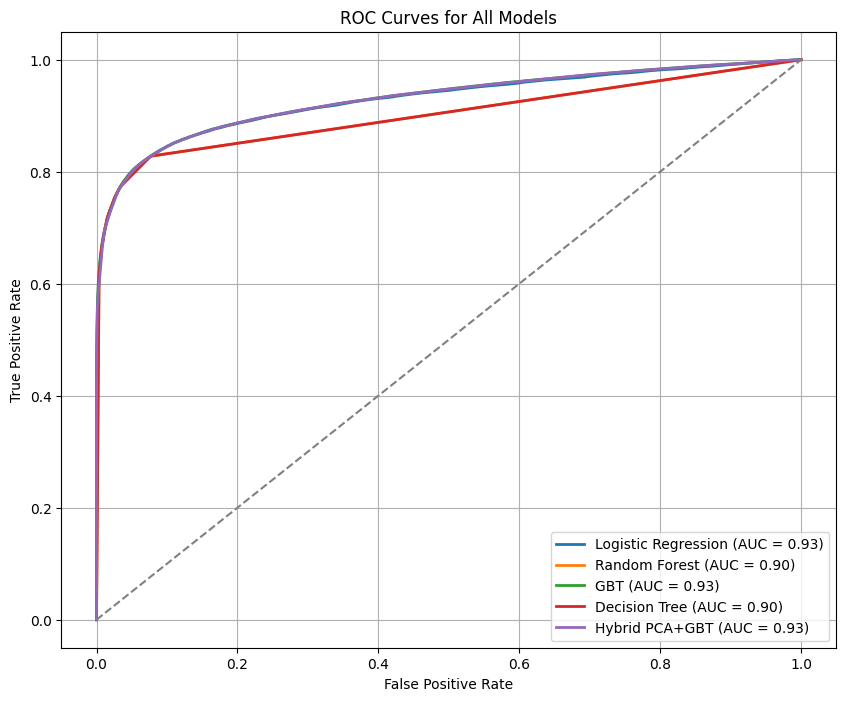

In [ ]:
plt.figure(figsize=(10, 8))

model_preds = {
    "Logistic Regression": pred_lr,
    "Random Forest": rf_model.transform(test),
    "GBT": gbt_model.transform(test),
    "Decision Tree": dt_model.transform(test),
    "Hybrid PCA+GBT": pred_hybrid
}

for model_name, pred_df in model_preds.items():
    pd_pred = pred_df.select("DELAYED", "probability").toPandas()
    if "probability" in pd_pred.columns:
        pd_pred["prob_1"] = pd_pred["probability"].apply(lambda x: float(x[1]))
        fpr, tpr, _ = roc_curve(pd_pred["DELAYED"], pd_pred["prob_1"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Spark Big Data Metrics

In [ ]:
print("Number of partitions:", df_clean.rdd.getNumPartitions())
df_clean.cache()
df_clean.count()
start_time = time.time()
df_clean.count()
end_time = time.time()
print("Cached count time:", round(end_time - start_time, 2), "s")
df_clean.groupBy("ORIGIN").count().explain(True)

Number of partitions: 5
Cached count time: 0.35 s
== Parsed Logical Plan ==
'Aggregate ['ORIGIN], ['ORIGIN, count(1) AS count#3215L]
+- Filter atleastnnonnulls(4, DEP_DELAY#29, ARR_DELAY#36, DISTANCE#43, DELAYED#81)
   +- Project [FL_DATE#17, AIRLINE#18, AIRLINE_DOT#19, AIRLINE_CODE#20, DOT_CODE#21, FL_NUMBER#22, ORIGIN#23, ORIGIN_CITY#24, DEST#25, DEST_CITY#26, CRS_DEP_TIME#27, DEP_TIME#28, DEP_DELAY#29, TAXI_OUT#30, WHEELS_OFF#31, WHEELS_ON#32, TAXI_IN#33, CRS_ARR_TIME#34, ARR_TIME#35, ARR_DELAY#36, CANCELLED#37, CANCELLATION_CODE#38, DIVERTED#39, CRS_ELAPSED_TIME#40, ... 9 more fields]
      +- Relation [FL_DATE#17,AIRLINE#18,AIRLINE_DOT#19,AIRLINE_CODE#20,DOT_CODE#21,FL_NUMBER#22,ORIGIN#23,ORIGIN_CITY#24,DEST#25,DEST_CITY#26,CRS_DEP_TIME#27,DEP_TIME#28,DEP_DELAY#29,TAXI_OUT#30,WHEELS_OFF#31,WHEELS_ON#32,TAXI_IN#33,CRS_ARR_TIME#34,ARR_TIME#35,ARR_DELAY#36,CANCELLED#37,CANCELLATION_CODE#38,DIVERTED#39,CRS_ELAPSED_TIME#40,... 8 more fields] csv

== Analyzed Logical Plan ==
ORIGIN: str

### H2O AutoML & Deep Learning

In [ ]:
h2o_df = h2o.H2OFrame(df_clean.select("DEP_DELAY", "DISTANCE", "DELAYED").toPandas())
h2o_df["DELAYED"] = h2o_df["DELAYED"].asfactor()
h2o_train, h2o_test = h2o_df.split_frame([0.8], seed=1234)

aml = H2OAutoML(max_models=5, max_runtime_secs=900, seed=1)
aml.train(x=["DEP_DELAY", "DISTANCE"], y="DELAYED", training_frame=h2o_train)
perf = aml.leader.model_performance(h2o_test)

dl_model = H2ODeepLearningEstimator(hidden=[100, 100], epochs=10)
dl_model.train(x=["DEP_DELAY", "DISTANCE"], y="DELAYED", training_frame=h2o_train)
perf_dl = dl_model.model_performance(h2o_test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


### Summary Comparison Table

In [ ]:
comparison_data = [
    ["Logistic Regression", auc_lr],
    ["Random Forest", auc_rf],
    ["Gradient Boosted Trees", auc_gbt],
    ["Decision Tree", auc_dt],
    ["Hybrid PCA+GBT", auc_hybrid],
    ["H2O AutoML Leader", perf.auc()],
    ["H2O Deep Learning", perf_dl.auc()]
]

comp_df = pd.DataFrame(comparison_data, columns=["Model", "AUC"])
print("\n Model Performance Comparison Table:")
print(comp_df.sort_values("AUC", ascending=False))


 Model Performance Comparison Table:
                    Model       AUC
2  Gradient Boosted Trees  0.929522
4          Hybrid PCA+GBT  0.929118
5       H2O AutoML Leader  0.928477
0     Logistic Regression  0.928007
6       H2O Deep Learning  0.926764
1           Random Forest  0.901077
3           Decision Tree  0.710533
